#  Neural Ordinary Differential Equations

If we want to build a continuous-time or continuous-depth model, differential equation solvers are a useful tool.  But how exactly can we treat `odeint` as a layer for building deep models?  The previous chapter showed how to compute its gradients, so the only thing missing is to give it some parameters.  This chapter will show how and why to do so.

In this chapter we won't be using any deep learning frameworks.  Instead, we'll build everything from scratch using differentiable Numpy commands available through JAX.

## Preliminaries: Training a residual network
As a warm-up, we can define a simple deep neural network in only a few lines:

In [ ]:
import jax.numpy as jnp

def relu(x):
  return jnp.maximum(0.0, x)

def mlp(params, inputs):
  # A multi-layer perceptron, i.e. a fully-connected neural network.
  for w, b in params:
    outputs = jnp.dot(inputs, w) + b  # Linear transform
    inputs = jnp.tanh(outputs)            # Nonlinearity
  return outputs

`mlp` is simply a composition of linear and nonlinear layers.  Its parameters `params` are a list of weight matrices and bias vectors.

To make larger models, we can always chain together or compose layers.  As a standard example, chaining together some smaller neural networks, such as `mlp` layers, adding each one's input to its output, is called a residual network:

In [ ]:
def resnet(params, inputs, depth):
  for i in range(depth):
    outputs = mlp(params, inputs) + inputs
  return outputs

To fit this model to data, we also need a loss, an initializer, and an optimizer: 

In [ ]:
import numpy.random as npr
from jax.api import jit, grad

resnet_depth = 3
def resnet_squared_loss(params, inputs, targets):
  preds = resnet(params, inputs, resnet_depth)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

# A simple gradient-descent optimizer.
@jit
def resnet_update(params, inputs, targets):
  grads = grad(resnet_squared_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


As a sanity check, let's fit our resnet to a toy 1D dataset (green circles) and plot the predictions of the trained model (blue curve):

Text(0, 0.5, 'output')

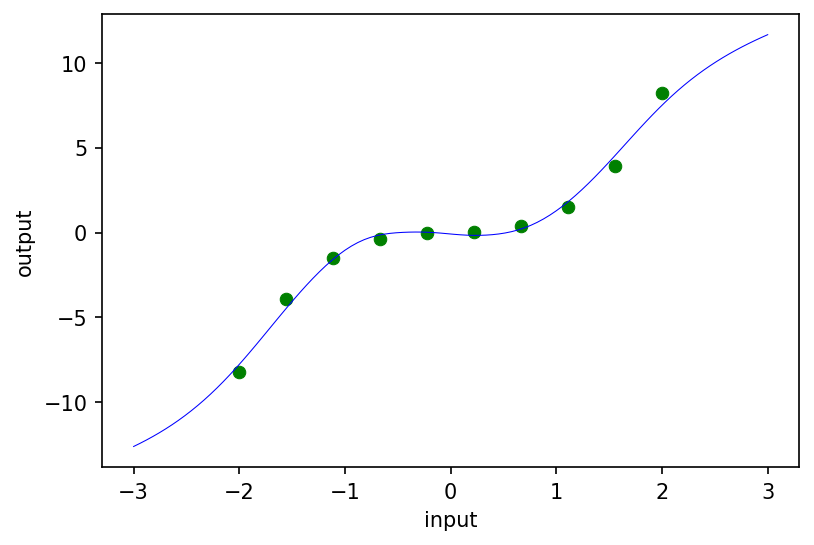

In [ ]:
# Toy 1D dataset.
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

# Hyperparameters.
layer_sizes = [1, 25, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, inputs, targets)

# Plot results.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')

## Building a neural ODE

Similar to a residual network, a neural ODE (or ODE-Net) takes a simple layer as a building block, and chains many copies of it together to buld a bigger model.  In particular, our "base layer" is going to specify the dynamics of an ODE, and we're going to chain the output of these base layers together according to the logic on an ODE solver.

### Specifying the dynamics layer

What kind of layer do we need to specify the dynamics of an ODE?
Recall that an ODE initial value problem has the form:
\begin{equation}
\dot y(t) = f(y(t), t,  \theta), \qquad y(0) = y_0,
\end{equation}
where the initial value $y_0 \in \mathbb{R}^n$.

We've added parameters $\theta$ to the dynamics, so the dynamics function has the dimensions $f : \mathbb{R}^{n} \times \mathbb{R} \times \mathbb{R}^{|\theta|} \to \mathbb{R}^n$, where $|\theta|$ is the number of parameters we've added to $f$.

In plain English, we need the dynamics function to take in the current state $y(t)$ of the ODE, the current time $t$, and some parameters $\theta$, and output $\frac{\partial y(t)}{\partial t}$, which has the same shape as $y(t)$.

We can easily build such a function by simply concatenating the state and current time, and sending that as the input to `mlp`:

In [ ]:
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)

The remaining part of our model that we need to specify is how to combine evaluations of this dynamics layer.  We could use any solver. JAX's `odeint` function implements the standard adapative-step Dormand-Price solver.

In [ ]:
from jax.experimental.ode import odeint

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params, atol=0.001, rtol=0.001)
  return final_state

Without loss of generality, we can make the integration time go from 0 to 1.

That's it!  We've defined an ODE net.  Below, we'll talk a bit more about what's happening inside of `odeint`, but for now, let's hook it up to an optimizer and see if we can fit it to data!

### Batching an ODE Net

To support batching (evaluating the ODE-Net on more than one training example) we can simply use Jax's `vmap` function, which automatically adds batching dimensions.
This transformation is non-trivial, since `odeint` contains while loops and control flow, but JAX can do it automatically.  The vmapped odeint creates independent parallel solvers running in parallel on each batch element, waiting for the last one to finish before returning all the final states together.  But it still combines the calls to the dynamics function into one efficient vectorized call shared across all batch elements.

In enviroments that don't have `vmap`, typically what's done is to create one giant ODE that combines the dynamics of every example in the batch, solve it all in one call to `odeint`, and then split up the results across the batch.

In [ ]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

What remains is simply to initialize the parameters, hook up the model to the loss function, and train the ODE-Net:

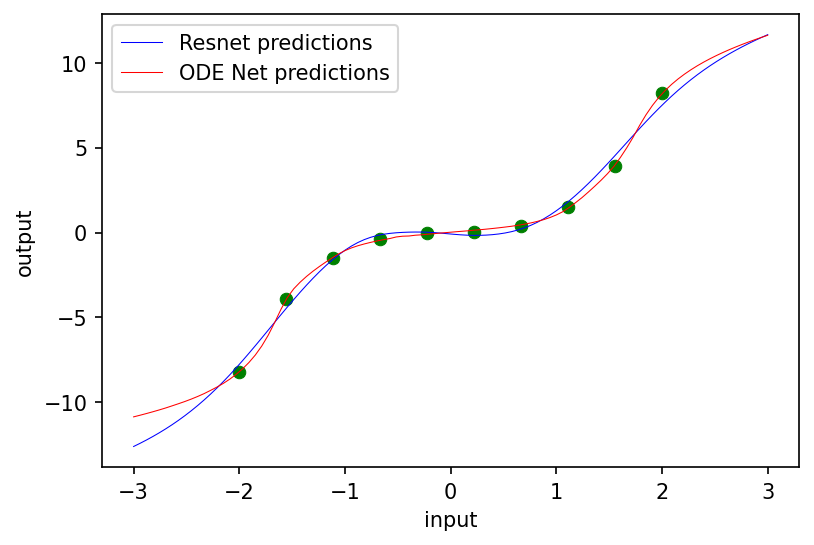

In [ ]:
# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))

The two regression methods both match the training data, but extrapolate slightly differently.

## Activation trajectories
In a deep residual network, we can examine the activations between each block.  In an ODE-Net, we can instead examing the activation _trajectories_ as a function of depth:

Text(0, 0.5, 'time / depth')

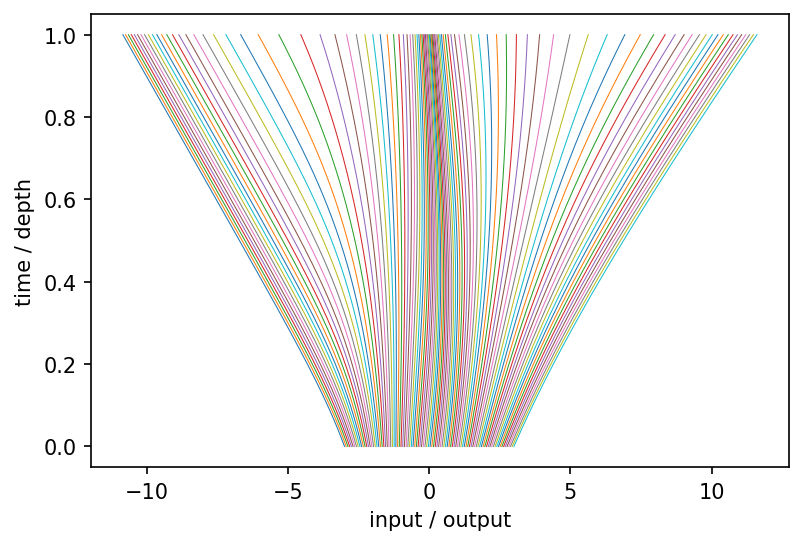

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()

@jit
def odenet_times(params, input, times):
  def dynamics_func(state, time, params):
    return mlp(params, jnp.hstack([state, jnp.array(time)]))
  return odeint(dynamics_func, input, times, params)

times = jnp.linspace(0.0, 1.0, 200)

for i in fine_inputs:
  ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

ax.set_xlabel('input / output')
ax.set_ylabel('time / depth')


In this toy setting where there is only one hidden unit, the trajectories can never cross each other, limiting the classes of functions that can be learned.  However, this limitation can be overcome (if desired) by [adding auxiliary dimensions](https://arxiv.org/abs/1904.01681) to the network's input that are discarded at the network output.





### What form can the dynamics take?
There are a few restrictions to make the ODE solution well-defined and unique which we will discuss later.  But in general it can be almost any tractable, differentiable, parametric function.  In other words, `odeint` is a layer that takes in another layer to specify its dynamics function.  This layer can be a fully-connected net, a convnet, U-net, or even [some kinds of transformer](https://arxiv.org/pdf/2006.04710.pdf)!


### Where can we use `odeint` layers?
The short answer is: anywhere you can use a residual net, you can use an ODENet.  Both require the size of the input to be the same size as the output.


## Computational advantages of neural ODEs

Why would we want to introduce all this extra complexity into our network architecture?  Like Deep Equilibrium Models, there are some computational advantages to implictly defining the output of our model, and leaving it up to an adaptive solver to approximate it:

 - ### Memory savings
   Sometimes memory is a limiting factor for training very large neural networks.  Specifically, memory use is usually dominated by storing the intermediate hidden unit activations in the whole neural network, necessary for computing training gradients.

   There are two main ways around this problem.  First, *checkpointing* means storing activations only at some layers, and re-computing the downstream layers as they're needed.  Second, [reversible architectures](https://arxiv.org/abs/1707.04585) constrain the neural network such that earlier layer's activations can be reconstructed from later layer's activations.  The downside is that this usually requires restricting the layer architectures in some major way, such as only updating half the units at a time.

   For training ODE-based models, we have another option. One nice property of exact ODE solutions is that they're always exactly reversible!  In principle, if you know the state at any single time, you can always reconstruct the entire trajectory of an ODE forwards and backwards from there.  Running an ODE backwards in time is equivalent to running the same ODE forwards in time but with the dynamics replaced by $\dot y = -f(-t, y)$.  This means that ODE Nets can, in principle, be trained with a memory cost constant in the number of evaluations of `f`, while a standard resnet would have a memory cost that grows linearly.

   In practice, this is only feasible if the ODE isn't too hard to solve in either direction, in which case the forward and reverse paths might not match, or could be too expensive to approximately finely enough.  However, if this happens, one can usually detect it by checking if the initial and final states match, and if so, simply do some checkpointing at the cost of some extra time.  Perhaps surprisingly, on large systems parameterized by neural networks, reconstructing the trajectory in reverse usually seems to work well enough to train in practice.

 - ### Adaptive computation

  We would like our models to spend their compute resources wisely, and only think hard about difficult problems whose answer is important.  Adaptive ODE solvers, developed over the last 120 years or so, achieve this in a limited way.

  The standard approach to building adaptive ODE solvers is to monitor the difference in the predicted trajectory made by two different extrapolation methods.  If this difference grows large, it suggests that at least one of the extrapolations methods is making bad predictions.  These methods then attempt to recover by starting over and making predictions less far ahead (i.e. taking smaller steps through time).

  Different solvers can handle different sorts of dynamics more or less easily, but generally speaking, the simpler the dynamics, the fewer steps an adaptive solver will need to approximate the answer to a given accuracy.

 - ### Ability to trade off speed and precision at both train and test time.

  Most adaptive ODE solvers require the user to specify an error tolerance (both relative and absolute) that the solver will try to meet.  For most real systems, we can't guarantee that any particular error target will be met.  But even in that case, the error tolerance is a way to trade off compute time against the precision of the answer.  This is a more flexible approach in some ways than weight pruning or quantization, since tolerances can be adjusted throughout training, or even after the model has been deployed.

## Modeling advantages of neural ODEs

  Besides having different computational tradeoff from fixed-depth networks, exact solutions of ODE-based networks are also different model class than standard neural nets, with a few different properties:

 - ### Tractable Change of Variables
  Sometimes in physics, taking the continuous-time limit of a discrete process simplifies the resulting calculations.  This happens to be true for normalizing flow models, which build a complex density through a discrete series of invertible transformations of a simpler base density.  The [FFJORD](https://arxiv.org/abs/1810.01367) model uses this approach.
 
 - ### Continuous-time time series models.
  There is a large literature on fitting continuous-time time series models, which are especially useful for dealing with irregularly-sampled time series data.  [Here's a review](http://proceedings.mlr.press/v119/li20k.html).  ODE-based models can handle this kind of data naturally.

 - ### Learning smooth homeomorphisms
   In cases where we do want to parameterize a homeomorphism, for instance when parameterizing a non-self-intersecting shape, continuous-time normalizing flows enforce this constraint automatically.  For example, [PointNet](https://github.com/charlesq34/pointnet) fits 3D surfaces to data using this approach.

## Modeling disadvantages of neural ODEs
  - ### Restrictions on activation functions.
  ODE solutions are not necessarily uniquely defined if their dynamics aren't continuously differentiable and Lipshitz.  Common activation functions like `tanh` and `relu` satisfy these conditions.  However, the second condition means we can't use some types of attention, so extra care needs to be taken when using [transformer-based dynamics](https://arxiv.org/pdf/2006.04710.pdf).
  
  - ### Can only learn smooth homeomorphisms.
    In situations where we don't want to learn a homeomorphism, we might need to [augment our state with extra dimensions](https://arxiv.org/abs/1904.01681) in order to recover the same sorts of universality that standard neural networks enjoy.  [This paper](https://arxiv.org/abs/1907.12998) makes these claims precise.

  - ### Deterministic dynamics.
    One problem with building a time-series model using ODEs is that they assume that the dynamics are deterministic.  So any sort of unknown or stochastic change to the state has to be added separately to the model.  One major family of stochastic continuous-time dynamics are given by stochastic differental equations, which can also be [fit by gradient descent](https://arxiv.org/pdf/2001.01328.pdf).

## Computational disadvantages of neural ODEs
 - ### Speed.
   This is the main reason not to use neural ODEs.  Specifically, ODE Nets will generally require more inner layer evaluations than a fixed architecture on the same task.  What makes this even worse is that during training, the dynamics being learn tend to become more and more expensive to solve.  This makes sense, if we think of the network as "learning to be deep" and expressing a more complex function.  However, we want to balance predictive performance against compute cost, so we need to somehow encourage our model to be east to solve.  There is some recent work on regularizing ODEs to be easier to solve:
    - [Learning Differential Equations that are Easy to Solve](https://arxiv.org/abs/2007.04504)
    - [How to train your neural ODE: the world of Jacobian and kinetic regularization](https://arxiv.org/abs/2002.02798)

- ### Extra hyperparameters.
  In standard nets, we have to choose the depth of the network as a hyperparameter.  In ODE Nets, we instead need to specify the error tolerance of our solver, as well as the solver strategy.
  


## Software

Here are a few of the more comprehensive toolkits that let one fit neural ODES:

 - [TorchDiffEq](https://github.com/rtqichen/torchdiffeq) - A PyTorch library purpose-build for building and fitting neural ODE models.
 - [Jax](https://github.com/google/jax) - A general-purpose numerical computing framework for Python, which includes a differentiable Dopri5 solver.
 - [JuliaDiffEq](https://github.com/SciML/DifferentialEquations.jl) - A comprehensive suite of differential equation solvers for the Julia language.
 - [TorchDyn](https://github.com/diffeqml/torchdyn) - A suite of model templates, tutorials, and application notebooks.

## Stochastic and Partial Differential Equations

Besides ordinary differential equations, there are many other variants of differential equations that can be fit by gradients, and developing new model classes based on differential equations is an active research area.  The solution of almost any type of differential equation can be seen as a layer!

Here are some pointers to recent work in these areas:
 - [ICLR Workshop on Integration of Deep Neural Models and Differential Equations](http://iclr2020deepdiffeq.rice.edu/)
 - [Scalable Gradients for Stochastic Differential Equations](https://arxiv.org/pdf/2001.01328.pdf)
 - [Learning composable energy surrogates for PDE order reduction](https://arxiv.org/abs/2005.06549)
 - [Amortized finite element analysis for fast PDE-constrained optimization](https://openreview.net/forum?id=0XCli3H-8F)


